In [9]:
##### Importing packages #####
import numpy as np
import math as math
import matplotlib.pyplot as plt
import scipy as sc
from scipy import interpolate
from numba import jit
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [10]:
##### Helping functions #####

### Compute eigenvectors and eigenvalues
@jit(nopython=True)
def eigen(x,y,z):
    xi1, xi2, xi3 = np.empty((3)), np.empty((3)), np.empty((3))
    xi1[0], xi1[1], xi1[2] = x*z, y*z, -y**2 - x**2
    xi2[0], xi2[1], xi2[2] = y, -x, 0
    xi3[0], xi3[1], xi3[2] = x, y, z
    #if (x == 0 and y == 0):
    #    xi2[0], xi2[1] = 1, -1
    #    xi1[0], xi1[1] = 1, 1
    xi3 = normalize(xi3)
    xi2 = normalize(xi2)
    xi1 = normalize(xi1)
    return xi1, xi2, xi3

# Normalizing vector r
@jit(nopython=True)
def normalize(r):
    norm = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
    return r/norm

# Compute component of vector r1 that is orthogonal to vector r2
@jit(nopython=True)
def orthogonalComponent(r1,r2):
    return r1 - r2*(r1[0]*r2[0]+r1[1]*r2[1]+r1[2]*r2[2])/(r1[0]**2+r1[1]**2+r1[2]**2)

In [11]:
##### More specialized helping functions #####

# Attempting to advect the start position towards the plane initiating from r
@jit(nopython=True)
def flowmap(qr, r, r0, r1, r2, r_delta, dr, jmax, norm, D):
    tol = 10**(-2)
    j = 0
    qr0 = qr
    r_aim = r + D*normalize(orthogonalComponent(r_delta, r2-r1))
    while(not inplane(qr, r, r_delta, norm, tol) and j < jmax):
        xi1, xi2 = eigen(qr[0],qr[1],qr[2])[0:2]
        a1, a2 = aim(qr0, r, r_aim, xi1, xi2)
        qr = qrRK2(qr, dr, a1, a2, xi1, xi2)
        j += 1
    return qr, (j < jmax)

# RK2 solver distributed over two functions
@jit(nopython=True)
def qrRK2(qr, d, a1, a2, xi1, xi2):
    k = np.empty((2,3))
    k[0,:] = makek(a1, a2, xi1, xi2)
    xi1, xi2 = eigen(qr[0]+k[0,0]*d, qr[1]+k[0,1]*d ,qr[2]+k[0,2]*d)[0:2]
    k[1,:] = makek(a1, a2, xi1, xi2)
    return qr + (k[0,:] + k[1,:])*d/2

@jit(nopython=True)
def makek(a1, a2, xi1, xi2):
    k = np.empty((1,3))
    k[0,0] = a1*xi1[0] + a2*xi2[0]
    k[0,1] = a1*xi1[1] + a2*xi2[1]
    k[0,2] = a1*xi1[2] + a2*xi2[2]
    return k

# Projecting the direction towards r into the manifold
@jit(nopython=True)
def aim(qr0, r, r_aim, xi1, xi2):
    return np.dot(normalize(r_aim-qr0),xi1), np.dot(normalize(r_aim-qr0),xi2)

# Checks whether the position qr is in the plane Fr defined by point r and corresponding normal
@jit(nopython=True)
def inplane(qr, r, r_delta, norm, tol):
    return (np.absolute(np.dot(normalize(qr - r), normalize(norm))) < tol and np.dot(qr - r, r_delta) > 0)

# Returns the neighboring points of a specific point on the level set
@jit(nopython=True)
def neighborpoints(levelset, i):
    n = levelset.shape[1]
    r1 = levelset[:,divmod(i-1,n)[1]]
    r2 = levelset[:,divmod(i+1,n)[1]]
    if (np.linalg.norm(levelset[:,i]-r1) < np.linalg.norm(r2 - levelset[:,i])):
        r2 = levelset[:,i] + np.linalg.norm(levelset[:,i]-r1)*normalize(r2 - levelset[:,i])
    elif (np.linalg.norm(levelset[:,i] - r1) > np.linalg.norm(r2 - levelset[:,i])):
        r1 = levelset[:,i] - np.linalg.norm(r2 - levelset[:,i])*normalize(levelset[:,i] - r1)
    return r1, r2

# Adjusts the plane normal defined by neighbor points for difference in distance to these neighbor points
@jit(nopython=True)
def planenorm(r, r1, r2):
    if (np.linalg.norm(r - r1) < np.linalg.norm(r2 - r)):
        r2 = r + np.linalg.norm(r - r1)*normalize(r2 - r)
    elif (np.linalg.norm(r - r1) > np.linalg.norm(r2 - r)):
        r1 = r - np.linalg.norm(r2 - r)*normalize(r - r1)
    return r2 - r1

# Makes proxy comparison "last step vector" by weighting of neighboring points
@jit(nopython=True)
def weightRadialVectors(r, r1, r2, rv1, rv2):
    d1 = np.linalg.norm(r - r1)
    d2 = np.linalg.norm(r2 - r)
    return (d1*rv1 + d2*rv2)/(d1 +d2)
    
# Tests whether any steps changed too much in terms of angle from the last steps
@jit(nopython=True)
def alphaTest(RadialVectors, newRadialVectors, amin, amax):
    ubound, lbound = False, False
    for i in range(RadialVectors.shape[1]):
        if (np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) > amax):
            ubound = True
            return ubound, lbound # lbound doesnt matter if we have ubound
        elif (np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) < amin):
            lbound = True
    return ubound, lbound

# Similar to above, only including step length
@jit(nopython=True)
def deltaAlphaTest(RadialVectors, newRadialVectors, D, damin, damax):
    ubound, lbound = False, False
    for i in range(RadialVectors.shape[1]):
        if (D*np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) > damax):
            ubound = True
            return ubound, lbound # lbound doesnt matter if we have ubound
        elif (D*np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) < damin):
            lbound = True
    return ubound, lbound

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def df_check(newLevelSet, df, dF):
    deletes = []
    n = newLevelSet.shape[1]
    sep = np.empty(n)
    for i in range(0, n):
        sep[i] = np.linalg.norm(newLevelSet[:,divmod(i+1,n)[1]] - newLevelSet[:,i])
    i = 0
    j = 0
    while (i < n):
        if (sep[i] < df and sep[i] + min(sep[divmod(i-1,n)[1]],sep[divmod(i+1,n)[1]]) < dF):
            if (sep[divmod(i-1,n)[1]] < sep[divmod(i+1,n)[1]]):
                sep[divmod(i-1,n)[1]] = sep[i] + sep[divmod(i-1,n)[1]]
                sep = np.delete(sep,i,0)
                deletes.append(i + j)
                n -= 1
                j += 1
            else:
                sep[i] = sep[i] + sep[divmod(i+1,n)[1]]
                sep = np.delete(sep,divmod(i+1,n)[1],0)
                deletes.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return deletes #delete index

# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
@jit(nopython=True)
def dF_check(newLevelSet, dF):
    appends = []
    n = newLevelSet.shape[1]
    sep = np.empty(n)
    for i in range(0, n):
        sep[i] = np.linalg.norm(newLevelSet[:,divmod(i+1,n)[1]] - newLevelSet[:,divmod(i,n)[1]])
    for i in range(0,n):
        if (sep[i] > dF):
            appends.append(i)
    return appends #append after index

In [12]:
##### GeodesicLevelSets support functions #####

# Initiate variables needed to search iteratively for an acceptable new point 
def initiateD(S0, r, r0, r1, r2, r_delta, dr, jmax, norm, D, Dtol, tck, minstep, maxstep):
    S, dS, over, hit = S0+minstep, minstep, False, True
    qr = np.asarray(sc.interpolate.splev(S, tck))
    
    qr, hitnow = flowmap(qr, r, r0, r1, r2, r_delta, dr, jmax, norm, D)
    if (hitnow):
        Di = np.linalg.norm(qr-r)
    else:
        Di = -1
    return S, dS, Di, qr, over, hit

# Iteratively search for acceptable new point
def computeD(S, dS, Smax, Di, over, hit, r, r0, r1, r2, r_delta, qr, dr, jmax, norm, maxiter, minstep, maxstep, D, Dtol, tck):
    j = 0
    backtracked = False
    while((Di < D*(1-Dtol) or Di > D*(1+Dtol)) and j < maxiter and S < Smax):
        j += 1
        S, dS, over, hit, backtracked = nextS(S, dS, Di, D, Dtol, minstep, maxstep, over, hit, backtracked)
        qr = np.asarray(sc.interpolate.splev(S, tck))
        qr, hitnow = flowmap(qr, r, r0, r1, r2, r_delta, dr, jmax, norm, D)
        
        if (hitnow):
            Di = np.linalg.norm(qr-r)
        else:
            Di = -1
    toadd = ((j < maxiter) and (S < Smax))
    if (j >= maxiter):
        print('Maximum iterations reached')
        print('S =', S)
    if (S >= Smax):
        print('S >= Smax')
    return qr, toadd
 
# Suggest a new geodesic level circle parameter S from which to search for a new acceptable point
@jit(nopython=True)
def nextS(S, dS, Di, D, Dtol, minstep, maxstep, over, hit, backtracked):
    if (hit):
        if (over):
            if (Di < 0):
                if (dS > minstep):
                    return S - 0.9*dS, 0.1*dS, over, hit, True
                else:
                    return S + dS, dS, over, False, False
            elif (Di > D*(1+Dtol)):
                if (dS < maxstep):
                    if (backtracked):
                        return S + dS, dS, True, True, backtracked
                    else:
                        return S + 10*dS, 10*dS, True, True, backtracked
                else: #Should never be backtracked here
                    return S + dS, dS, True, True, False
            else: #(Di < D*(1-Dtol)):
                if (dS > minstep):
                    return S - 0.9*dS, 0.1*dS, over, hit, True
                else:
                    return S + dS, dS, False, True, False
        else: #(not over)
            if (Di < 0):
                if (dS > minstep):
                    return S - 0.9*dS, 0.1*dS, over, hit, True
                else:
                    return S + dS, dS, over, False, False
            elif (Di > D*(1+Dtol)):
                if (dS > minstep):
                    return S - 0.9*dS, 0.1*dS, False, hit, True
                else:
                    return S + dS, dS, True, True, False
            else: #(Di < D*(1-Dtol)):
                if (dS < maxstep):
                    if (backtracked):
                        return S + dS, dS, False, True, backtracked
                    else:
                        return S + 10*dS, 10*dS, False, True, backtracked
                else:
                    return S + dS, dS, False, True, False
    else: # (not hit))
        if (Di < 0):
            if (dS < maxstep):
                if (backtracked):
                    return S + dS, dS, over, False, backtracked
                else:
                    return S + 10*dS, 10*dS, over, False, backtracked
            else:
                return S + dS, dS, over, False, False
        elif (Di > D*(1+Dtol)):
            if (dS > minstep):
                return S - 0.9*dS, 0.1*dS, over, hit, True
            else:
                if (backtracked):
                    return S + dS, dS, True, True, backtracked
                else:
                    return S + 10*dS, 10*dS, True, True, backtracked
        else: #(Di < D*(1-Dtol)):
            if (dS > minstep):
                return S - 0.9*dS, 0.1*dS, over, hit, True
            else:
                if (backtracked):
                    return S + dS, dS, False, True, backtracked
                else:
                    return S + 10*dS, 10*dS, False, True, backtracked

In [25]:
### GeodesicLevelSet class

# Class definition
class GeodesicLevelSet:
    def __init__(self, r_init, dr, num, D, D0, Dtol, jmax, ptol, maxiter, minstep, maxstep, amin, amax, damin, damax, 
                 df, dF):
        # Parameters
        self.r_init = r_init
        self.dr = dr
        self.num = num
        self.D = D
        self.D0 = D0
        # Tolerances/time management
        self.Dtol = Dtol
        self.jmax = jmax
        self.ptol = ptol
        self.maxiter = maxiter
        self.minstep = minstep
        self.maxstep = maxstep
        # Mesh management input parameters
        self.amin = amin
        self.amax = amax
        self.damin = damin
        self.damax = damax
        self.df = df
        self.dF = dF
        # Saving levels sets in list of numpy arrays
        self.LevelSets = []
        self.RadialVectors = []
  
    # Adding startin geodesic level circle
    def addStartSet(self):
        xi1, xi2 = eigen(self.r_init[0],self.r_init[1],self.r_init[2])[0:2]
        d = 2*np.pi/self.num
        Sd, Sdr = np.empty((3, self.num)), np.empty((3, self.num))
        Sd[0,:] = self.r_init[0]*np.ones((1,self.num))
        Sd[1,:] = self.r_init[1]*np.ones((1,self.num))
        Sd[2,:] = self.r_init[2]*np.ones((1,self.num))
        for i in range(0,self.num):
            Sd[:,i] += xi1*np.sin(i*d)*self.D0
            Sd[:,i] += xi2*np.cos(i*d)*self.D0
        Sdr[0,:] = Sd[0,:] - self.r_init[0]*np.ones((self.num))
        Sdr[1,:] = Sd[1,:] - self.r_init[1]*np.ones((self.num))
        Sdr[2,:] = Sd[2,:] - self.r_init[2]*np.ones((self.num))
        for i in range(0,self.num):
            Sdr[:,i] = normalize(Sdr[:,i])
        self.LevelSets.append(Sd)
        self.RadialVectors.append(Sdr)
        return
    
    # Adding a new geodesic level circle
    def addLevelSet(self):
        start = time.time()
        newLevelSet = []
        newRadialVectors = []
        for i in range(0,self.LevelSets[-1].shape[1]):
            r = self.LevelSets[-1][:,i]
            r1, r2 = neighborpoints(self.LevelSets[-1], i)
            norm = planenorm(r, r1, r2)
            tck, u = sc.interpolate.splprep([np.append(self.LevelSets[-1][0,i:], self.LevelSets[-1][0,0:i+1]),
                                        np.append(self.LevelSets[-1][1,i:], self.LevelSets[-1][1,0:i+1]),
                                        np.append(self.LevelSets[-1][2,i:], self.LevelSets[-1][2,0:i+1])], k=3, s=0)
            S, dS, Di, qr, over, hit = initiateD(S0=0, r=r, r0=self.r_init, r1=r1, r2=r2, 
                                        r_delta=self.RadialVectors[-1][:,i], dr=self.dr, jmax=self.jmax, norm=norm,
                                        D=self.D, Dtol=self.Dtol, tck=tck, minstep=self.minstep, maxstep=self.maxstep)
            newpoint, toadd = computeD(S=S, dS=dS, Smax=S+1, Di=Di, over=over, hit=hit, r=r, r0=self.r_init,
                                        r1=r1, r2=r2, r_delta=self.RadialVectors[-1][:,i], qr=qr, dr=self.dr,
                                        jmax=self.jmax, norm=norm, maxiter=self.maxiter, minstep=self.minstep,
                                        maxstep=self.maxstep, D=self.D, Dtol=self.Dtol, tck=tck)
            if (toadd):
                newLevelSet.append(newpoint)
                newRadialVectors.append(normalize(newpoint - r))
            else:
                print('Failed, but trying again')
                s0 = 1/(2*self.LevelSets[-1].shape[1])
                failed = True
                for S0 in [s0/100, -s0/100, s0/50, -s0/50, s0/10, -s0/10]:
                    r = np.asarray(sc.interpolate.splev(S0, tck))
                    # Might want to update r_delta with change in S0
                    S, dS, Di, qr, over, hit = initiateD(S0=S0, r=r, r0=self.r_init, r1=r1, r2=r2, 
                                                r_delta=self.RadialVectors[-1][:,i], dr=self.dr, jmax=self.jmax, norm=r2-r1,
                                                D=self.D, Dtol=self.Dtol, tck=tck, minstep=self.minstep, maxstep=self.maxstep)
                    newpoint, toadd = computeD(S=S, dS=dS, Smax=S+1, Di=Di, over=over, hit=hit, r=r, r0=self.r_init,
                                                r1=r1, r2=r2, r_delta=self.RadialVectors[-1][:,i], qr=qr, dr=self.dr,
                                                jmax=self.jmax, norm=r2-r1, maxiter=self.maxiter, minstep=self.minstep,
                                                maxstep=self.maxstep, D=self.D, Dtol=self.Dtol, tck=tck)
                    if (toadd):
                        #print('Adding:', newpoint)
                        newLevelSet.append(newpoint)
                        newRadialVectors.append(normalize(newpoint - r))
                        failed = False
                        break
                if (failed):
                    print('Failed to cover up failure')
        newLevelSet, newRadialVectors = np.asarray(newLevelSet).T, np.asarray(newRadialVectors).T
        a_ubound, a_lbound = alphaTest(self.RadialVectors[-1], newRadialVectors, self.amin, self.amax)
        da_ubound, da_lbound = deltaAlphaTest(self.RadialVectors[-1], newRadialVectors, self.D, self.damin, self.damax)
        if (self.D/2 >= self.df and (a_ubound or da_ubound)):
            print('D halved')
            self.D = 0.5*self.D
            self.dr = 0.5*self.dr
        elif (a_lbound and da_lbound and 2*self.D <= self.dF):
            print('D doubled')
            # Adding points
            makeafter = dF_check(newLevelSet, self.dF)
            if (len(makeafter) > 0):
                print('Additions to be made after:', makeafter)
                newLevelSet, newRadialVectors = self.FillInLevelSet(newLevelSet, newRadialVectors, makeafter)
            # Removing points
            deletes = df_check(newLevelSet, self.df, self.dF)
            if (len(deletes) > 0):
                print('To be deleted:', deletes)
                removed = 0
                for i in deletes:
                    newLevelSet = np.delete(newLevelSet, i-removed, 1)
                    newRadialVectors = np.delete(newRadialVectors, i-removed, 1)
                    removed += 1
            self.LevelSets.append(newLevelSet)
            self.RadialVectors.append(newRadialVectors)
            self.D = 2*self.D
            self.dr = 2*self.dr
        else:
            # Adding points
            makeafter = dF_check(newLevelSet, self.dF)
            if (len(makeafter) > 0):
                print('Additions to be made after:', makeafter)
                newLevelSet, newRadialVectors = self.FillInLevelSet(newLevelSet, newRadialVectors, makeafter)
            # Removing points
            deletes = df_check(newLevelSet, self.df, self.dF)
            if (len(deletes) > 0):
                print('To be deleted:', deletes)
                removed = 0
                for i in deletes:
                    newLevelSet = np.delete(newLevelSet, i-removed, 1)
                    newRadialVectors = np.delete(newRadialVectors, i-removed, 1)
                    removed += 1
            self.LevelSets.append(newLevelSet)
            self.RadialVectors.append(newRadialVectors) 
        print('Geodesic level set number', len(self.LevelSets), 'compeleted in %.2f' % round(time.time() - start, 2),
              'seconds.')
        return
    
    # Filling in points in geodesic level circle if points are too far from each other
    def FillInLevelSet(self, newLevelSet, newRadialVectors, makeafter):
        j = 0
        n = newLevelSet.shape[1]
        newaims = []
        newstarts = []
        for i in makeafter:
            r1, r2 = self.LevelSets[-1][:,i], self.LevelSets[-1][:,np.divmod(i+1,n)[1]]
            tck, u = sc.interpolate.splprep([np.append(self.LevelSets[-1][0,i:], self.LevelSets[-1][0,0:i+1]),
                                        np.append(self.LevelSets[-1][1,i:], self.LevelSets[-1][1,0:i+1]),
                                        np.append(self.LevelSets[-1][2,i:], self.LevelSets[-1][2,0:i+1])], k=3, s=0)
            r = np.asarray(sc.interpolate.splev(1/(2*self.LevelSets[-1].shape[1]), tck))
            r_delta = weightRadialVectors(r, r1, r2, self.RadialVectors[-1][:,i], self.RadialVectors[-1][:,np.divmod(i+1,n)[1]])
            S, dS, Di, qr, over, hit = initiateD(S0=1/(2*self.LevelSets[-1].shape[1]), r=r, r0=self.r_init, r1=r1, r2=r2, 
                                        r_delta=r_delta, dr=self.dr, jmax=self.jmax, norm=r2-r1,
                                        D=self.D, Dtol=self.Dtol, tck=tck, minstep=self.minstep, maxstep=self.maxstep)
            newpoint, toadd = computeD(S=S, dS=dS, Smax=S+1, Di=Di, over=over, hit=hit, r=r, r0=self.r_init,
                                        r1=r1, r2=r2, r_delta=r_delta, qr=qr, dr=self.dr,
                                        jmax=self.jmax, norm=r2-r1, maxiter=self.maxiter, minstep=self.minstep,
                                        maxstep=self.maxstep, D=self.D, Dtol=self.Dtol, tck=tck)
            if (toadd):
                newLevelSet = np.insert(newLevelSet, i+1+j, newpoint, 1)
                newRadialVectors = np.insert(newRadialVectors, i+1+j, normalize(newpoint - r), 1)
                j += 1
            else:
                print('Failed to fill in point, trying again')
                s0 = 1/(2*self.LevelSets[-1].shape[1])
                failed = True
                for S0 in [s0 + s0/10, s0 - s0/10, s0 + s0/5, s0 - s0/5, s0 + 3*s0/10, s0 - 3*s0/10]:
                    r = np.asarray(sc.interpolate.splev(S0, tck))
                    r_delta = weightRadialVectors(r, r1, r2, self.RadialVectors[-1][:,i], self.RadialVectors[-1][:,np.divmod(i+1,n)[1]])
                    S, dS, Di, qr, over, hit = initiateD(S0=S0, r=r, r0=self.r_init, r1=r1, r2=r2, 
                                                r_delta=r_delta, dr=self.dr, jmax=self.jmax, norm=r2-r1,
                                                D=self.D, Dtol=self.Dtol, tck=tck, minstep=self.minstep, maxstep=self.maxstep)
                    newpoint, toadd = computeD(S=S, dS=dS, Smax=S+1, Di=Di, over=over, hit=hit, r=r, r0=self.r_init,
                                                r1=r1, r2=r2, r_delta=r_delta, qr=qr, dr=self.dr,
                                                jmax=self.jmax, norm=r2-r1, maxiter=self.maxiter, minstep=self.minstep,
                                                maxstep=self.maxstep, D=self.D, Dtol=self.Dtol, tck=tck)
                    if (toadd):
                        newLevelSet = np.insert(newLevelSet, i+1+j, newpoint, 1)
                        newRadialVectors = np.insert(newRadialVectors, i+1+j, normalize(newpoint - r), 1)
                        j += 1
                        failed = False
                        break
                if (failed):
                    print('Failed to cover up failure')
        return newLevelSet, newRadialVectors

In [26]:
test = GeodesicLevelSet(r_init=np.asarray([0,1,0]), dr=0.01, num=20, D=0.1, D0=0.01, Dtol=0.01, jmax=1000, ptol=0.01,
                        maxiter=10000, minstep=1e-4, maxstep=1e-2, amin=0.01, amax=0.1, damin=0.01, damax=0.1, 
                        df=0.02, dF=0.1)

In [27]:
test.addStartSet()

In [28]:
num = 50
start = time.time()
for i in range(num):
    test.addLevelSet()
print(num, 'Level sets computed in', time.time()-start, 'seconds.')

Geodesic level set number 2 compeleted in 0.06 seconds.
D halved
Geodesic level set number 2 compeleted in 0.62 seconds.
Geodesic level set number 3 compeleted in 0.74 seconds.
Geodesic level set number 4 compeleted in 0.38 seconds.
Geodesic level set number 5 compeleted in 0.28 seconds.
Geodesic level set number 6 compeleted in 0.67 seconds.
Additions to be made after: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Geodesic level set number 7 compeleted in 0.10 seconds.
Geodesic level set number 8 compeleted in 0.34 seconds.
Geodesic level set number 9 compeleted in 0.30 seconds.
Geodesic level set number 10 compeleted in 0.02 seconds.
Geodesic level set number 11 compeleted in 0.55 seconds.
Geodesic level set number 12 compeleted in 0.42 seconds.
Additions to be made after: [1, 21]
Geodesic level set number 13 compeleted in 0.02 seconds.
Additions to be made after: [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29,

In [29]:
### Functions for preparing reference sphere

def Zval(X,Y):
    Z = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (1 - X[i,j]**2 - Y[i,j]**2 >= 0):
                Z[i,j] = np.sqrt(1 - X[i,j]**2 - Y[i,j]**2)
            else:
                Z[i,j] = 0
    return Z

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

def zeroToNan(Z):
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if (Z[i,j] == 0):
                Z[i,j] = float('nan')
    return Z

<IPython.core.display.Javascript object>


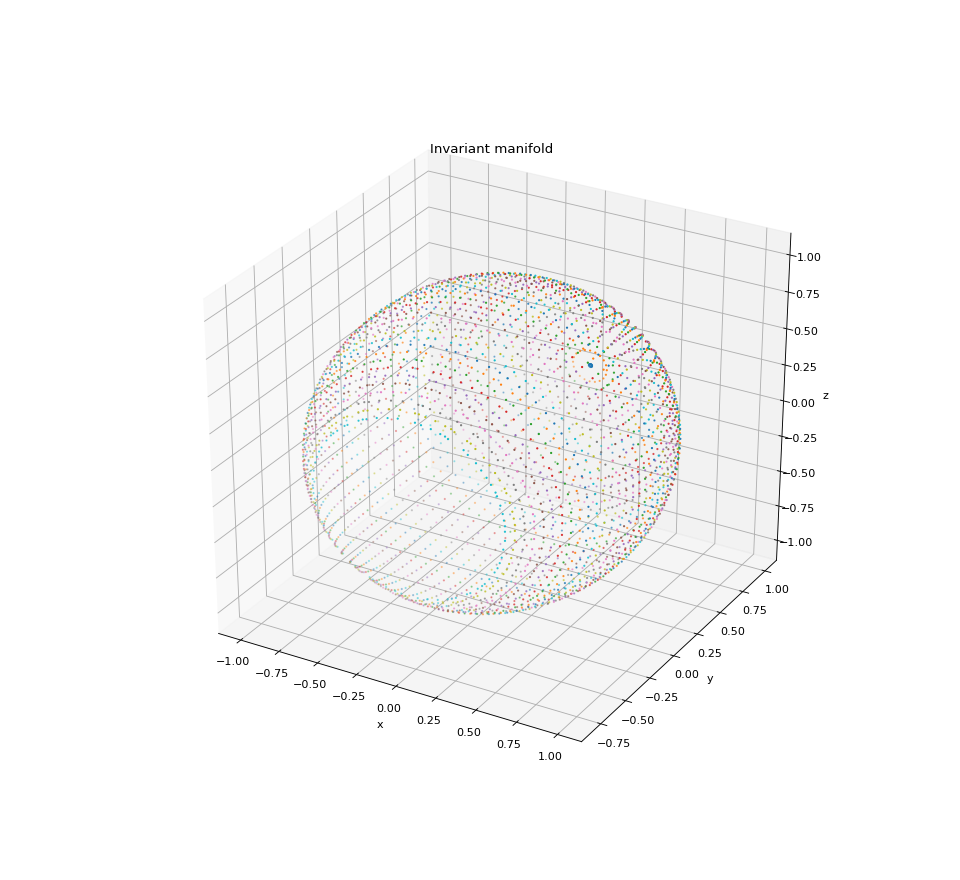

In [34]:
##### Plotting #####

fig = plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')

#theta = np.linspace(0, 2*np.pi, 100)
#X = np.sin(theta)
#Y = np.cos(theta)
#X, Y = np.meshgrid(X, Y)
#Z1 = zeroToNan(Zval(X,Y))
#Z2 = zeroToNan(-Zval(X,Y))

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=10)
#ax.plot_wireframe(X, Y, Z2, rstride=10, cstride=10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)
#ax.set_zlim(-1,1)

plt.title('Invariant manifold')
for i in range(0,len(test.LevelSets)):
    ax.scatter(test.LevelSets[i][0],test.LevelSets[i][1], test.LevelSets[i][2], s=1)

plt.show()